
# Read Data and Define X and Y

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
data = pd.read_csv('pima_indian_data.csv')
data.head()

,Number of times pregnant,Plasma glucose,Diastolic blood pressure,Triceps skinfold thickness,serum insulin,Body mass index,Diabetes pedigree function,Age,Class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Data Inspection

In [104]:
data.isna().sum().sum()

0

### Note : No missing values , no imputation needed

In [105]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Number of times pregnant,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Plasma glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
Diastolic blood pressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
Triceps skinfold thickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
serum insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
Body mass index,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
Diabetes pedigree function,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Class,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


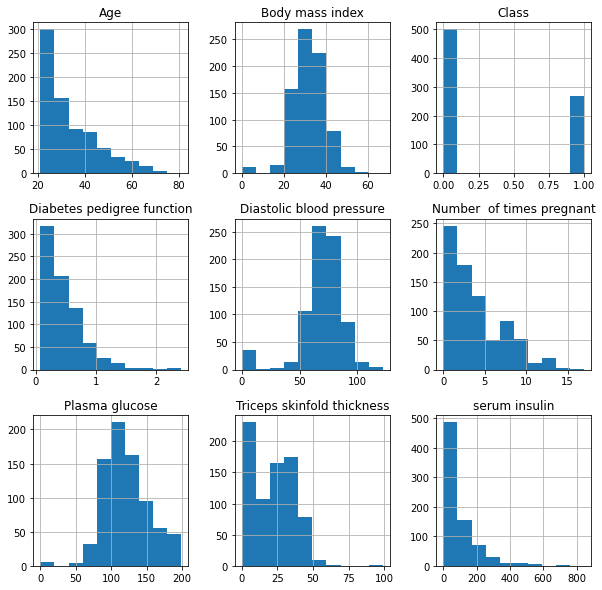

In [106]:
import matplotlib.pyplot as plt
%matplotlib inline

data.hist(figsize=(10,10))
plt.show()

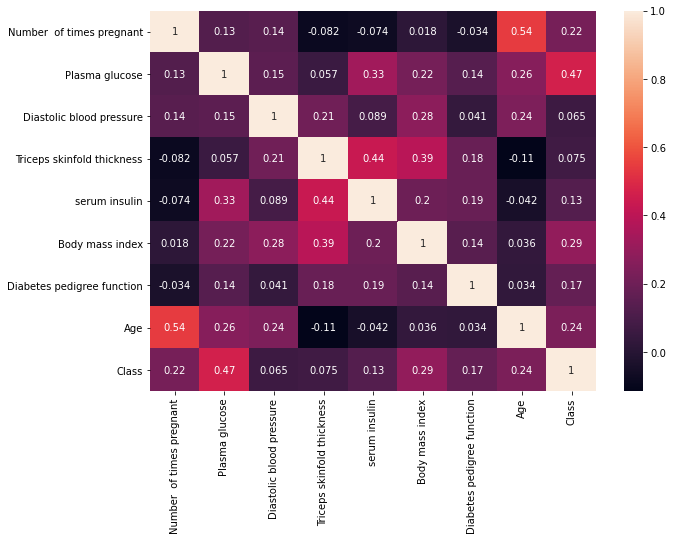

In [107]:
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),annot=True)

plt.show()

In [108]:
X=data.drop(columns=['Class'],axis=1)
y=data['Class']

### spliting dataset into training and testing

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

print(f'Training sample: {X_train.shape[0]:,}')
print(f'Test sample: {X_test.shape[0]:,}')

Training sample: 614
Test sample: 154


## Logistic Regression without gridsearch and cross validation

In [110]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

modeling_pipeline = Pipeline([('scaling', StandardScaler()),
                              ('pca', PCA(n_components=5)),
    ('mnl', LogisticRegression(fit_intercept=True))])

In [111]:
modell= modeling_pipeline.fit(X_train, y_train)

In [112]:
from sklearn.metrics import confusion_matrix
y_test_pred = modell.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

[[94 14]
 [23 23]]


In [113]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.80      0.87      0.84       108
           1       0.62      0.50      0.55        46

    accuracy                           0.76       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.75      0.76      0.75       154



In [114]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve

def generate_probs(X, model=modell):
    return model.predict_proba(X)[:, 1]

def generate_roc(y, probs):
    fpr, tpr, _ = roc_curve(y, probs)
    return fpr, tpr

recall_score(y_test, y_test_pred)

0.5

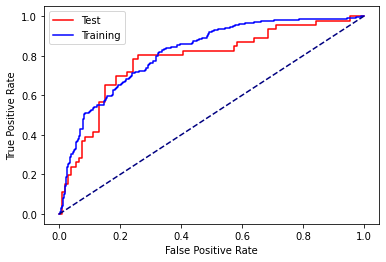

In [115]:
    
fpr_test, tpr_test = generate_roc(y_test, generate_probs(X_test))
fpr_train, tpr_train = generate_roc(y_train, generate_probs(X_train))

plt.plot(fpr_test, tpr_test,'-r')
plt.plot(fpr_train, tpr_train,'-b')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Test','Training'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

## Logistic Regression with gridsearch and cross validation

In [116]:

from sklearn.model_selection import GridSearchCV
param_grid = [{'mnl__solver': ['liblinear', 'saga'],
               'mnl__C':[0.5,1,1.5,2,10],
               'mnl__class_weight':[None,'balanced'],
              'mnl__max_iter':[1000,2000,3000],
              'mnl__penalty':['l1','l2']}]

gcv_results = GridSearchCV(estimator = modeling_pipeline, param_grid=param_grid, n_jobs=-1,refit='neg_log_loss', cv=10, verbose=2, scoring = 'recall', return_train_score=True)

gcv_results = gcv_results.fit(X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 1185 out of 1200 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    5.1s finished


In [117]:
gcv_results.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_mnl__C', 'param_mnl__class_weight', 'param_mnl__max_iter', 'param_mnl__penalty', 'param_mnl__solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])

In [118]:
gcv_results.best_score_

0.7112648221343874

In [119]:
gcv_results.best_params_

{'mnl__C': 0.5,
 'mnl__class_weight': 'balanced',
 'mnl__max_iter': 1000,
 'mnl__penalty': 'l1',
 'mnl__solver': 'liblinear'}

In [120]:
gcv_results.best_estimator_

Pipeline(steps=[('scaling', StandardScaler()), ('pca', PCA(n_components=5)),
                ('mnl',
                 LogisticRegression(C=0.5, class_weight='balanced',
                                    max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [121]:
from sklearn.metrics import confusion_matrix
y_test_pred = gcv_results.predict(X_test)
print(confusion_matrix(y_test, y_test_pred))

[[83 25]
 [12 34]]


In [122]:

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82       108
           1       0.58      0.74      0.65        46

    accuracy                           0.76       154
   macro avg       0.72      0.75      0.73       154
weighted avg       0.78      0.76      0.77       154



In [123]:
recall_score(y_test, y_test_pred)

0.7391304347826086

## Why recall?

#### As it classifcation model , we cannot define the goodness of model using accuracy. So decided to be use recall or precision. Data is about the diabetes classification , more than precision i am interested in recall so the people who are really having diabetes are not missed out. 

## Observations

#### Recall increased from 52 % to 70 % after fitting the model with  grid search cross-validation using 10 folds. 
####  5 different regularization strengths and 2 solvers - liblinear and saga